<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC1_Turbofan_FD001_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [2]:
# Enable HalvingSearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [58]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

from sklearn.exceptions import ConvergenceWarning

In [ ]:
from warnings import simplefilter

In [3]:
sns.set_palette('colorblind')

# Data Preparation

In [134]:
class DatasetProcessing:
    def download_data(self):
        os.system('git clone https://github.com/arthursl12/dataset_2')
        os.system('mv /content/dataset_2/CMaps /content/CMaps')
        os.system('rm -rf dataset_2')

    def column_names(self):
        index_cols = ['unit_number', 'time']
        settings_cols = ['op_1', 'op_2', 'op_3']
        sensors_cols = [f's_{i}'for i in range(21)]
        cols = index_cols + settings_cols + sensors_cols
        return index_cols, settings_cols, sensors_cols, cols

    def read_dataset(self,scenario=1):
        folder='/content/CMaps/'
        _,_,_,cols = self.column_names()
        train = pd.read_csv(
            (folder+f'train_FD00{scenario}.txt'), 
            sep='\s+', header=None, names=cols)
        test = pd.read_csv(
            (folder+f'test_FD00{scenario}.txt'), 
            sep='\s+', header=None, names=cols)
        y_test = pd.read_csv(
            (folder+f'RUL_FD00{scenario}.txt'), 
            sep='\s+', header=None, names=['RUL'])
        return train, test, y_test

    def transform_test(self,test):
        # Take only the last line for each test set
        # Because it is the only annotated line
        test_last = test.groupby('unit_number').last().reset_index()

        # Dropping unnecessary columns
        idx_c, set_c, _, _ = self.column_names()
        test_last = test_last.drop(idx_c+set_c, axis=1)
        return test_last

    # RUL: how many cycles remain ? 
    #   Take the last (maximun) cycle registered ('time' column) for that sample
    #   Subtract from current cycle number
    #   i.e. assume linear RUL decay
    def add_remaining_useful_life_linear(self,df):
        # Get the total number of cycles for each unit
        grouped_by_unit = df.groupby(by="unit_number")
        max_cycle = grouped_by_unit["time"].max()
        
        # Merge the max cycle back into the original frame
        result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), 
                                left_on='unit_number', right_index=True)
        
        # Calculate remaining useful life for each row
        remaining_useful_life = result_frame["max_cycle"] - result_frame["time"]
        result_frame["RUL"] = remaining_useful_life
        
        # drop max_cycle as it's no longer needed
        result_frame = result_frame.drop("max_cycle", axis=1)
        return result_frame

    def X_y_train_divide(self,train_df):
        # Separate X_train and y_train from train_df
        # i.e., separate RUL column from train_df
        if ('RUL' not in train_df.columns):
            train = self.add_remaining_useful_life_linear(train_df)
        else:
            train = train_df
        y_train = pd.DataFrame(train['RUL'])
        X_train = train
        X_train = X_train.drop(index_cols+settings_cols+['RUL'], axis=1)
        return X_train, y_train

In [135]:
proc = DatasetProcessing()

In [ ]:
# Dataset download
proc.download_data()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [22]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(1)
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## Preprocessing

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [38]:
test.shape, y_test.shape

((13096, 26), (100, 1))

In [136]:
test_last = proc.transform_test(test)
test_last.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


### Remaining Useful Life (RUL)

In [26]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


# Training and Evaluation functions

In [140]:
class Evaluation:
    def rmse(self, y_true, y_pred):
        mse = mean_squared_error(y_pred, y_true)
        return np.sqrt(mse)

    def show_result(self, y_true, y_pred):
        print(f"R2={r2_score(y_true, y_pred):.3f},"+
              f"RMSE={-self.rmse(y_true, y_pred):.3f}")

    def show_result_cv(self, y_true, X_train, model):
        r2_res = cross_val_score(model, X_train, y_true, 
                                 cv=5, scoring='r2').mean()
        rmse_res = cross_val_score(model, X_train, y_true, cv=5, 
                                scoring='neg_root_mean_squared_error').mean()
        print(f"(CV) R2={r2_res:.3f},"+
              f"RMSE={rmse_res:.3f}")
    
    def print_training_results(self, model, X_train, y_train):
        self.show_result(y_train, model.predict(X_train))
        self.show_result_cv(y_train, X_train, model)
    
    def print_test_results(self, model, X_test, y_test):
        self.show_result(y_test, model.predict(X_test))

In [141]:
eval = Evaluation()

In [142]:
def reclipper_scorer(estimator, X_train, y_train):
    # Computes R2 score, but clips y_train again, as it was done for training
    reclipped_y =  estimator['trf_reg'].transformer.transform(y_train)
    return r2_score(reclipped_y, estimator.predict(X_train))

In [154]:
class HyperparameterSearch:
    def generate_clip_dicts(self, first, last, step):
        # Generates a list of dictionaries with keys 'a_max' and 'a_min'
        # to use in grid search as kw_args of np.clip function
        # Will use range(first, last+1, step)
        list_of_dicts = []
        for a in range(first, last+1, step):
            a_dict = {}
            a_dict['a_min'] = 0
            a_dict['a_max'] = a
            list_of_dicts.append(a_dict)
        return list_of_dicts
    
    def run_HR_GS(self, base_model, X_train, y_train, param_distributions, 
                  print_best=True, ignore_warnings=False, 
                  scorer=reclipper_scorer):
        search = HalvingRandomSearchCV(base_model, param_distributions,
                                    min_resources=500, scoring=reclipper_scorer, 
                                    random_state=42, verbose=1)

        if (ignore_warnings): simplefilter("ignore", category=ConvergenceWarning)
        search.fit(X_train, y_train);
        if (ignore_warnings):simplefilter("default", category=ConvergenceWarning)

        if(print_best): print("Best params: ", search.best_params_)
        return search.best_estimator_
    
    def run_GS(self, base_model, X_train, y_train, param_distributions, 
               print_best=True, ignore_warnings=False, scorer=reclipper_scorer):
        search = GridSearchCV(base_model,param_distributions,
                            scoring=reclipper_scorer,verbose=1)

        if (ignore_warnings): simplefilter("ignore", category=ConvergenceWarning)
        search.fit(X_train, y_train);
        if (ignore_warnings):simplefilter("default", category=ConvergenceWarning)

        if(print_best): print("Best params: ", search.best_params_)
        return search.best_estimator_

In [155]:
search = HyperparameterSearch()

# LinearRegression

In [32]:
X_train, y_train = proc.X_y_train_divide(train)

In [33]:
y_train.head()

,RUL
0,191
1,190
2,189
3,188
4,187


In [34]:
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Linear Decay

In [145]:
model = LinearRegression()
model.fit(X_train, y_train)
eval.show_result(y_train, model.predict(X_train))
eval.show_result_cv(y_train, X_train, model)

R2=0.580,RMSE=-44.663
(CV) R2=0.569,RMSE=-44.666


In [146]:
X_test = test_last
eval.show_result(y_test, model.predict(X_test))

R2=0.409,RMSE=-31.950


## Non-linear decay

In [147]:
y_train.clip(upper=189).head()

,RUL
0,189
1,189
2,189
3,188
4,187


In [156]:
model = Pipeline([
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = LinearRegression(),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':50})))
    ])

In [157]:
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "trf_reg__transformer__kw_args": search.generate_clip_dicts(80,150,1)
    }
model = search.run_HR_GS(model, X_train, y_train, param_distributions)
model

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params:  {'trf_reg__transformer__kw_args': {'a_min': 0, 'a_max': 96}}


Pipeline(steps=[('trf_reg',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<function clip at 0x7f2135b39cb0>,
                                                                            kw_args={'a_max': 96,
                                                                                     'a_min': 0})))])

Best Model:

```
{'trf_reg__transformer__kw_args': {'a_min': 0, 'a_max': 96}}
```



In [158]:
model = Pipeline([
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = LinearRegression(),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':96})))
    ])

In [159]:
model.fit(X_train, y_train)
reclipped_y =  model['trf_reg'].transformer.transform(y_train)
eval.show_result(reclipped_y, model.predict(X_train))
eval.show_result_cv(reclipped_y, X_train, model)

R2=0.757,RMSE=-15.128
(CV) R2=0.753,RMSE=-15.224


In [160]:
eval.show_result(y_test, model.predict(X_test))

R2=0.623,RMSE=-25.526


In [72]:
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "trf_reg__transformer__kw_args": generate_clip_dicts(50,350,5)
    }

    search = HalvingRandomSearchCV(model, param_distributions,min_resources=500, scoring='r2', random_state=42, verbose=1)
    search.fit(X_train, y_train)
    print(search.best_params_)
    model = search.best_estimator_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'trf_reg__transformer__kw_args': {'a_min': 0, 'a_max': 215}}


In [63]:
model['trf_reg'].set_params

<bound method BaseEstimator.set_params of TransformedTargetRegressor(check_inverse=False, regressor=LinearRegression(),
                           transformer=FunctionTransformer(func=<function clip at 0x7f2135b39cb0>,
                                                           kw_args={'a_max': 90,
                                                                    'a_min': 0}))>

In [60]:
model['trf_reg'].get_params()

{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor': LinearRegression(),
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'transformer': FunctionTransformer(func=<function clip at 0x7f2135b39cb0>,
                     kw_args={'a_max': 90, 'a_min': 0}),
 'transformer__accept_sparse': False,
 'transformer__check_inverse': True,
 'transformer__func': <function numpy.clip>,
 'transformer__inv_kw_args': None,
 'transformer__inverse_func': None,
 'transformer__kw_args': {'a_max': 90, 'a_min': 0},
 'transformer__validate': False}

In [ ]:
model = Pipeline([
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = LinearRegression(),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':90})))
    ])

In [ ]:
model.fit(X_train, y_train)
reclipped_y =  model['trf_reg'].transformer.transform(y_train)
show_result(reclipped_y, model.predict(X_train))
show_result_cv(reclipped_y, X_train, model)

In [ ]:
reclipped_y_test = model['trf_reg'].transformer.transform(y_test)
show_result(y_test, model.predict(X_test))

In [ ]:
myrange = np.arange(10,150,10)
for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    # show_result(y_non_linear, model.predict(X_train))
    show_result_cv(y_non_linear, X_train, model)
    # score_mean = cross_val_score(model, X_train, y_non_linear, cv=5, scoring='r2').mean()
    # print(f"{k}: {score_mean:.3f}")

(CV) R2=0.244, RMSE=-1.164
(CV) R2=0.409, RMSE=-2.755
(CV) R2=0.527, RMSE=-4.381
(CV) R2=0.612, RMSE=-5.950
(CV) R2=0.670, RMSE=-7.467
(CV) R2=0.710, RMSE=-8.977
(CV) R2=0.735, RMSE=-10.544
(CV) R2=0.748, RMSE=-12.221
(CV) R2=0.753, RMSE=-14.049
(CV) R2=0.752, RMSE=-16.039
(CV) R2=0.745, RMSE=-18.176
(CV) R2=0.736, RMSE=-20.430
(CV) R2=0.724, RMSE=-22.760
(CV) R2=0.710, RMSE=-25.119


In [ ]:
myrange = np.arange(80,110,5)

for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    # show_result(y_non_linear, model.predict(X_train))
    # score_mean = cross_val_score(model, X_train, y_non_linear, cv=8, scoring='r2').mean()
    # print(f"{k}: {score_mean:.3f}")
    show_result_cv(y_non_linear, X_train, model)

(CV) R2=0.748, RMSE=-12.221
(CV) R2=0.752, RMSE=-13.115
(CV) R2=0.753, RMSE=-14.049
(CV) R2=0.753, RMSE=-15.025
(CV) R2=0.752, RMSE=-16.039
(CV) R2=0.749, RMSE=-17.091


In [ ]:
k = 90
y_non_linear = y_train.clip(upper=k)
model = LinearRegression()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.758, RMSE=-13.959
(CV) R2=0.753, RMSE=-14.049


In [ ]:
X_test = test_last
X_test = X_test.drop(index_cols+settings_cols, axis=1)

In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.565, RMSE=-27.397


# Transformer

In [39]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.clip, kw_args={'a_min':0,'a_max':50})
transformer.transform(y_train)

,RUL
0,50
1,50
2,50
3,50
4,50
...,...
20626,4
20627,3
20628,2
20629,1


In [56]:
model = Pipeline([
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = LinearRegression(),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':90})))
    ])

model.fit(X_train, y_train)
reclipped_y =  model['trf_reg'].transformer.transform(y_train)
show_result(reclipped_y, model.predict(X_train))
show_result_cv(reclipped_y, X_train, model)

R2=0.758, RMSE=-13.959
(CV) R2=0.753, RMSE=-14.049


In [57]:
reclipped_y_test = model['trf_reg'].transformer.transform(y_test)
show_result(y_test, model.predict(X_test))

R2=0.565, RMSE=-27.397


In [54]:
reclipped_y =  model['t_linear'].transformer.transform(y_train)
show_result(reclipped_y, model.predict(X_train))
show_result_cv(reclipped_y, X_train, model)

R2=0.758, RMSE=-13.959
(CV) R2=0.753, RMSE=-14.049


In [46]:
dir(model['t_linear'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_fit_transformer',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_training_dim',
 '_validate_data',
 'check_inverse',
 'feature_names_in_',
 'fit',
 'func',
 'get_params',
 'inverse_func',
 'n_features_in_',
 'predict',
 'regressor',
 'regressor_',
 'score',
 'set_params',
 'transformer',
 'transformer_']

In [47]:
model['t_linear'].regressor

LinearRegression()

In [48]:
model['t_linear'].transformer

FunctionTransformer(func=<function clip at 0x7f2135b39cb0>,
                    kw_args={'a_max': 90, 'a_min': 0})

In [50]:
model['t_linear'].transformer.kw_args

{'a_max': 90, 'a_min': 0}

In [49]:
dir(model['t_linear'].transformer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_input',
 '_check_inverse_transform',
 '_check_n_features',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_transform',
 '_validate_data',
 'accept_sparse',
 'check_inverse',
 'fit',
 'fit_transform',
 'func',
 'get_params',
 'inv_kw_args',
 'inverse_func',
 'inverse_transform',
 'kw_args',
 'set_params',
 'transform',
 'validate']

In [45]:
model['t_linear'].get_params()

{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor': LinearRegression(),
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'transformer': FunctionTransformer(func=<function clip at 0x7f2135b39cb0>,
                     kw_args={'a_max': 90, 'a_min': 0}),
 'transformer__accept_sparse': False,
 'transformer__check_inverse': True,
 'transformer__func': <function numpy.clip>,
 'transformer__inv_kw_args': None,
 'transformer__inverse_func': None,
 'transformer__kw_args': {'a_max': 90, 'a_min': 0},
 'transformer__validate': False}

In [ ]:
model['t_linear'].get_params()

## HuberRegressor

It's a linear regressor, but uses some optimization to become more stable to outliers in data

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor

model = Pipeline([
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   HuberRegressor())
])
model

Pipeline(steps=[('scaler', StandardScaler()), ('lin_reg', HuberRegressor())])

In [ ]:
y_non_linear = np.array(y_non_linear).ravel()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.756, RMSE=-14.010
(CV) R2=0.751, RMSE=-14.108


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.564, RMSE=-27.455


In [ ]:
from sklearn.model_selection import HalvingRandomSearchCV

GRID_SEARCH = False
if (GRID_SEARCH):
    param_distributions = {
        "lin_reg__epsilon": [1.35,2,3,3.5,4,4.5,5,6],
        "lin_reg__alpha":[1e-2,1e-3,1e-4,1e-5],
        "lin_reg__max_iter": [100,200,300],
        "lin_reg__tol": [1e-3,1e-4,1e-5,1e-6]
    }

    search = HalvingRandomSearchCV(model, param_distributions,min_resources=500, scoring='r2', random_state=42, verbose=1)
    search.fit(X_train, y_non_linear)
    print(search.best_params_)
    model = search.best_estimator_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'lin_reg__tol': 1e-05, 'lin_reg__max_iter': 200, 'lin_reg__epsilon': 3.5, 'lin_reg__alpha': 0.01}


GridSearch result: 

In [ ]:
model = Pipeline([
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   HuberRegressor(alpha=0.01, epsilon=3.5, max_iter=200, tol=1e-5))
])
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_reg',
                 HuberRegressor(alpha=0.01, epsilon=3.5, max_iter=200))])

In [ ]:
list(zip(model['lin_reg'].coef_, X_train.columns))

[(0.0, 's_0'),
 (-1.939770413552512, 's_1'),
 (-1.4701233479377314, 's_2'),
 (-3.2171761902340186, 's_3'),
 (-1.3851267819297736e-13, 's_4'),
 (1.1646067792858656, 's_5'),
 (3.337241976921652, 's_6'),
 (-1.3582081921803555, 's_7'),
 (-5.219384322716527, 's_8'),
 (0.0, 's_9'),
 (-4.772313627411685, 's_10'),
 (4.420542397725838, 's_11'),
 (-1.4625934986182794, 's_12'),
 (-3.8246821557799904, 's_13'),
 (-2.8141048209852855, 's_14'),
 (-1.0821302983826356e-15, 's_15'),
 (-1.5580290715541794, 's_16'),
 (0.0, 's_17'),
 (0.0, 's_18'),
 (1.9499012247330925, 's_19'),
 (1.899791818141464, 's_20')]

In [ ]:
y_non_linear = np.array(y_non_linear).ravel()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.753, RMSE=-16.987
(CV) R2=0.749, RMSE=-17.091


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.682, RMSE=-23.447


## SGD Regressor

The class SGDRegressor implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties to fit linear regression models. **SGDRegressor is well suited for regression problems with a large number of training samples (> 10.000)**, for other problems we recommend Ridge, Lasso, or ElasticNet.

In [ ]:
from sklearn.linear_model import SGDRegressor

model = Pipeline([
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   SGDRegressor())
])
model

Pipeline(steps=[('scaler', StandardScaler()), ('lin_reg', SGDRegressor())])

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

GRID_SEARCH = False
if (GRID_SEARCH):
    param_distributions = {
        "lin_reg__loss": ['squared_error', 'huber', 'epsilon_insensitive'],
        "lin_reg__penalty": ['l2', 'l1', 'elasticnet'],
        "lin_reg__epsilon": [1.1,1.35,1.5,2,2.5,3,3.5,4,4.5,5.5,6],
        "lin_reg__alpha":[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],
        "lin_reg__max_iter": [1000,1500,2000,2500,3000],
        "lin_reg__tol": [1e-3,1e-4,1e-5,1e-6,1e-7],
        "lin_reg__learning_rate": ['invscaling', 'constant', 'optimal', 'adaptive'],
        "lin_reg__eta0": [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6],
        "lin_reg__power_t": [1.25,1,0.75,0.5,0.25,0.1],
        "lin_reg__early_stopping": [True,False],
        "lin_reg__validation_fraction": [0.1,0.2,0.3,0.4,0.5,0.6],
        "lin_reg__n_iter_no_change": [1,2,5,8,10,15,20],
        "lin_reg__average": [False, 1,2,5,10,20]
    }

    search = HalvingRandomSearchCV(model, param_distributions,min_resources=500, scoring='r2', random_state=42, verbose=1)

    simplefilter("ignore", category=ConvergenceWarning)
    search.fit(X_train, y_non_linear);
    simplefilter("default", category=ConvergenceWarning)

    print(search.best_params_)
    model = search.best_estimator_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'lin_reg__validation_fraction': 0.5, 'lin_reg__tol': 0.0001, 'lin_reg__power_t': 1.25, 'lin_reg__penalty': 'l2', 'lin_reg__n_iter_no_change': 5, 'lin_reg__max_iter': 1500, 'lin_reg__loss': 'squared_error', 'lin_reg__learning_rate': 'constant', 'lin_reg__eta0': 0.01, 'lin_reg__epsilon': 2, 'lin_reg__early_stopping': False, 'lin_reg__average': 10, 'lin_reg__alpha': 1e-06}


SGDRegressor(alpha=1e-05, epsilon=2.5, eta0=1e-05, learning_rate='constant',
             max_iter=2000, n_iter_no_change=8, penalty='elasticnet', power_t=1,
             validation_fraction=0.3)

SGDRegressor(alpha=1e-06, average=10, epsilon=2, learning_rate='constant',
             max_iter=1500, power_t=1.25, tol=0.0001, validation_fraction=0.5)

In [ ]:
model = Pipeline([
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   SGDRegressor(alpha=1e-06, average=10, epsilon=2, 
                                 learning_rate='constant',max_iter=1500, 
                                 power_t=1.25, tol=0.0001, 
                                 validation_fraction=0.5))
])
model

In [ ]:
y_non_linear = np.array(y_non_linear).ravel()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.753, RMSE=-16.987
(CV) R2=0.749, RMSE=-17.092


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.681, RMSE=-23.463


Looks like we reached a "ceiling" of about .75 in the training and .68 in the test with those features. It is indeed, the coefficients are the same from the Huber regressor.

In [ ]:
list(zip(model['lin_reg'].coef_, X_train.columns))

[(0.0, 's_0'),
 (-1.9239215133977747, 's_1'),
 (-1.44925180502876, 's_2'),
 (-3.2009258114839967, 's_3'),
 (-1.3842954963747668e-13, 's_4'),
 (1.1645153239637336, 's_5'),
 (3.3855209615427597, 's_6'),
 (-1.399497590412796, 's_7'),
 (-5.181610284180236, 's_8'),
 (0.0, 's_9'),
 (-4.739627618078229, 's_10'),
 (4.3990979046559415, 's_11'),
 (-1.4157350784460954, 's_12'),
 (-3.827386489862775, 's_13'),
 (-2.8044241783940014, 's_14'),
 (-1.0814808565427865e-15, 's_15'),
 (-1.5878216565063104, 's_16'),
 (0.0, 's_17'),
 (0.0, 's_18'),
 (1.9303562127071716, 's_19'),
 (1.9645579513938225, 's_20')]

# PolyFeatures

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('poly_ft'  ,   PolynomialFeatures()),
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   LinearRegression())
])
model

Pipeline(steps=[('poly_ft', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [ ]:
y_non_linear = np.array(y_non_linear).ravel()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.788, RMSE=-15.759
(CV) R2=0.784, RMSE=-15.874


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.711, RMSE=-22.325


Just adding the polinomials we got a better result in the bare LinearRegressor.

In [ ]:
sorted(list(zip(model['lin_reg'].coef_, model['poly_ft'].get_feature_names_out())), reverse=True)[:10]

[(183037631406355.78, 's_10'),
 (70315245321450.664, 's_4 s_16'),
 (46165349935508.64, 's_10 s_15'),
 (44577798039313.45, 's_19'),
 (40831457201767.766, 's_14'),
 (40497514691911.61, 's_4 s_5'),
 (36566155386646.22, 's_5^2'),
 (35883457543472.97, 's_3'),
 (30218020945062.03, 's_9 s_16'),
 (29831687982515.723, 's_4 s_10')]

In [ ]:
model = Pipeline([
    ('poly_ft'  ,   PolynomialFeatures()),
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   SGDRegressor())
])
model

Pipeline(steps=[('poly_ft', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('lin_reg', SGDRegressor())])

In [ ]:
GRID_SEARCH = False
if (GRID_SEARCH):
    param_distributions = {
        "poly_ft__degree": [1,2,3],
        "poly_ft__interaction_only": [False, True],
        "poly_ft__include_bias": [True, False],
        "lin_reg__loss": ['squared_error', 'huber', 'epsilon_insensitive'],
        "lin_reg__penalty": ['l2', 'l1', 'elasticnet'],
        "lin_reg__epsilon": [1.1,1.35,1.5,2,2.5,3,3.5,4,4.5,5.5,6],
        "lin_reg__alpha":[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],
        "lin_reg__max_iter": [1000,1500,2000,2500,3000],
        "lin_reg__tol": [1e-3,1e-4,1e-5,1e-6,1e-7],
        "lin_reg__learning_rate": ['invscaling', 'constant', 'optimal', 'adaptive'],
        "lin_reg__eta0": [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6],
        "lin_reg__power_t": [1.25,1,0.75,0.5,0.25,0.1],
        "lin_reg__early_stopping": [True,False],
        "lin_reg__validation_fraction": [0.1,0.2,0.3,0.4,0.5,0.6],
        "lin_reg__n_iter_no_change": [1,2,5,8,10,15,20],
        "lin_reg__average": [False, 1,2,5,10,20]
    }

    search = HalvingRandomSearchCV(model, param_distributions,min_resources=500, scoring='r2', random_state=42, verbose=1)

    simplefilter("ignore", category=ConvergenceWarning)
    search.fit(X_train, y_non_linear);
    simplefilter("default", category=ConvergenceWarning)

    print(search.best_params_)
    model = search.best_estimator_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'poly_ft__interaction_only': True, 'poly_ft__include_bias': False, 'poly_ft__degree': 3, 'lin_reg__validation_fraction': 0.1, 'lin_reg__tol': 1e-05, 'lin_reg__power_t': 1, 'lin_reg__penalty': 'l1', 'lin_reg__n_iter_no_change': 10, 'lin_reg__max_iter': 3000, 'lin_reg__loss': 'epsilon_insensitive', 'lin_reg__learning_rate': 'adaptive', 'lin_reg__eta0': 0.01, 'lin_reg__epsilon': 3, 'lin_reg__ea

In [ ]:
model

Pipeline(steps=[('poly_ft',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('lin_reg',
                 SGDRegressor(alpha=1e-05, epsilon=3, learning_rate='adaptive',
                              loss='epsilon_insensitive', max_iter=3000,
                              n_iter_no_change=10, penalty='l1', power_t=1,
                              tol=1e-05))])

PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)

SGDRegressor(alpha=1e-05, epsilon=3, learning_rate='adaptive',
             loss='epsilon_insensitive', max_iter=3000, n_iter_no_change=10,
             penalty='l1', power_t=1, tol=1e-05)

In [ ]:
model = Pipeline([
    ('poly_ft'  ,   PolynomialFeatures(
                        degree=3, include_bias=False, interaction_only=True)),
    ('scaler'   ,   StandardScaler()),
    ('lin_reg'  ,   SGDRegressor(
            alpha=1e-05, epsilon=3, learning_rate='adaptive',
            loss='epsilon_insensitive', max_iter=3000, n_iter_no_change=10,
            penalty='l1', power_t=1, tol=1e-05))
])
model

Pipeline(steps=[('poly_ft',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('lin_reg',
                 SGDRegressor(alpha=1e-05, epsilon=3, learning_rate='adaptive',
                              loss='epsilon_insensitive', max_iter=3000,
                              n_iter_no_change=10, penalty='l1', power_t=1,
                              tol=1e-05))])

In [ ]:
y_non_linear = np.array(y_non_linear).ravel()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.788, RMSE=-15.733
(CV) R2=0.782, RMSE=-15.979


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.730, RMSE=-21.599


In [ ]:
sorted(list(zip(model['lin_reg'].coef_, model['poly_ft'].get_feature_names_out())), reverse=True)[:10]

[(12.262846613621925, 's_3 s_8 s_13'),
 (11.587100799714776, 's_8 s_10 s_13'),
 (10.984776488804373, 's_8 s_13 s_14'),
 (10.895631516866016, 's_8 s_13 s_16'),
 (10.570921904623182, 's_2 s_8 s_13'),
 (10.159164217155679, 's_6 s_10 s_20'),
 (9.845748259619967, 's_10 s_11 s_20'),
 (9.640089469145405, 's_6 s_10 s_19'),
 (9.469190726459034, 's_10 s_11 s_19'),
 (8.426903868959537, 's_3 s_6 s_19')]

## PCA


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

(20631, 1)

In [ ]:
y_train.shape

(20631,)

In [ ]:
model.intercept_

80325.06817555537

In [ ]:
model.coef_

array([ 0.00000000e+00, -3.09254758e+00, -2.01791223e-01, -2.87405064e-01,
       -1.53557304e-13,  8.37114696e+02,  3.05078280e+00, -2.04305644e+01,
       -1.97621175e-01, -1.43351997e-12, -1.44637363e+01,  4.99477546e+00,
       -1.96790156e+01, -1.81235894e-01, -6.18787371e+01, -2.29507035e-13,
       -7.85107117e-01, -2.86985925e-41,  4.48415509e-44,  8.26242716e+00,
        1.40421405e+01])

In [ ]:
m = pca.transform(model.coef_.reshape(1, -1))[0][0]
m

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


-12340.193403800411

In [ ]:
X_train_pca.shape

(20631, 1)

In [ ]:
model.predict(X_train).reshape(-1,1)

array([[93.95174766],
       [92.66347832],
       [96.7605066 ],
       ...,
       [12.88498912],
       [ 9.85883871],
       [12.42342569]])

Text(0, 0.5, 'RUL')

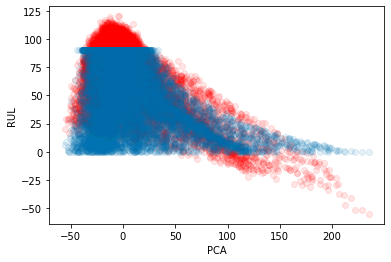

In [ ]:
plt.scatter(X_train_pca,model.predict(X_train).reshape(-1,1), color='r', alpha=0.1)
plt.scatter(X_train_pca,y_non_linear, alpha=0.1)
plt.xlabel("PCA")
plt.ylabel("RUL")

# Random Forest Regressor

In [ ]:
y_train = train['RUL']
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [ ]:
k = 90
y_non_linear = y_train.clip(upper=k)

In [ ]:
X_train = train
X_train = X_train.drop(index_cols+settings_cols+['RUL'], axis=1)
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [ ]:
show_result(y_train, model.predict(X_train))
show_result_cv(y_train, X_train, model)

R2=0.946, RMSE=-15.939
(CV) R2=0.594, RMSE=-43.277


In [ ]:
# ~40min
from sklearn.model_selection import HalvingRandomSearchCV

GRID_SEARCH = False
if (GRID_SEARCH):
    param_distributions = {"n_estimators": [50,100,200,500],
                        "criterion": ['squared_error','absolute_error','poisson'],
                        "max_depth": [None, 50, 100, 150],
                        "min_samples_split": [2,5,10]
                        }

    search = HalvingRandomSearchCV(model, param_distributions,min_resources=500, scoring='r2', random_state=42, verbose=1)
    search.fit(X_train_sc, y_non_linear)
    print(search.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 500
max_resources_: 20631
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 500
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 1500
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 4500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 13500
Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 500}

{'criterion': 'squared_error', 'max_depth': 100, 'n_estimators': 200}  
{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 500}

In [ ]:
model = RandomForestRegressor(criterion='squared_error', max_depth=None, 
                              min_samples_split=10, n_estimators=500,
                              random_state=42)
model.fit(X_train, y_non_linear)

RandomForestRegressor(min_samples_split=10, n_estimators=500, random_state=42)

In [ ]:
show_result(y_non_linear, model.predict(X_train))
show_result_cv(y_non_linear, X_train, model)

R2=0.958, RMSE=-5.809
(CV) R2=0.852, RMSE=-10.862


In [ ]:
show_result(y_test, model.predict(X_test))

R2=0.669, RMSE=-23.914
